In [2]:
from importlib import reload
from typing import Dict, List

import numpy as np
import numpy.typing as npt
import scipy.io as sio
import seaborn
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, losses

import spectrum_painting as sp
from spectrogram import Spectrogram, split_spectrogram
from spectrogram import create_spectrogram

In [3]:
def load_data_from_matlab(file: str) -> npt.NDArray[np.complex128]:
    """
    Load the list of complex numbers from Matlab files.
    """
    # each complex number is in its own row and so is put in
    # its own array. 'squeeze' flattens the array.
    return sio.loadmat(file)["WaveformOut"].squeeze()


data: Dict[str, npt.NDArray[np.complex128]] = {
    "z": load_data_from_matlab("data/matlab/Z_SNR30.mat"),
    "b": load_data_from_matlab("data/matlab/B_SNR30.mat"),
    "w": load_data_from_matlab("data/matlab/W_SNR30.mat"),
    "bw": load_data_from_matlab("data/matlab/BW_SNR30.mat"),
    "zb": load_data_from_matlab("data/matlab/ZB_SNR30.mat"),
    "zw": load_data_from_matlab("data/matlab/ZW_SNR30.mat"),
    "zbw": load_data_from_matlab("data/matlab/ZBW_SNR30.mat"),
}

In [4]:
def plot_spectrogram(spectrogram: Spectrogram):
    plt.pcolormesh(spectrogram.f, spectrogram.t, spectrogram.values.T, shading="nearest")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Time (s)")
    plt.title("Spectrogram")
    plt.colorbar(label="Magnitude (dB)")
    plt.show()

In [5]:
# Sampling frequency
fs = 20000000  # 20MHz

spectrograms: Dict[str, Spectrogram] = {key: create_spectrogram(frame, fs) for key, frame in data.items()}

In [6]:
reload(sp)
# middle: int = len(spectrograms["zbw"].values) // 2
# start_freq: int = middle - 40
# end_freq: int = middle + 40
# 
# demo_spectrogram = sp.take_frequencies(spectrograms["zbw"], start_freq, end_freq)
# demo_spectrogram = split_spectrogram(demo_spectrogram, 1000)[0]
# demo_spectrogram.values = demo_spectrogram.values.clip(0, 0.0000001)
# 
# plt.pcolormesh(demo_spectrogram.f, demo_spectrogram.t, demo_spectrogram.values.T, shading="nearest")
# plt.show()
# 
# demo_spectrogram = sp.downsample_spectrogram(demo_spectrogram.values, 16)
# plt.imshow(demo_spectrogram.T)
# plt.show()
# 
# augmented_demo_spectrogram = sp.augment_spectrogram(spectrogram=demo_spectrogram, k=4, l=3, d=1)
# plt.imshow(augmented_demo_spectrogram)
# plt.show()
# 
# demo_spectrogram = sp.paint_spectrogram(demo_spectrogram, augmented_demo_spectrogram)
# demo_spectrogram = sp.digitize_spectrogram(demo_spectrogram, 256)
# plt.imshow(demo_spectrogram)
# plt.show()

<module 'spectrum_painting' from '/Users/sethd/Desktop/spectrum-painting/training/spectrum_painting.py'>

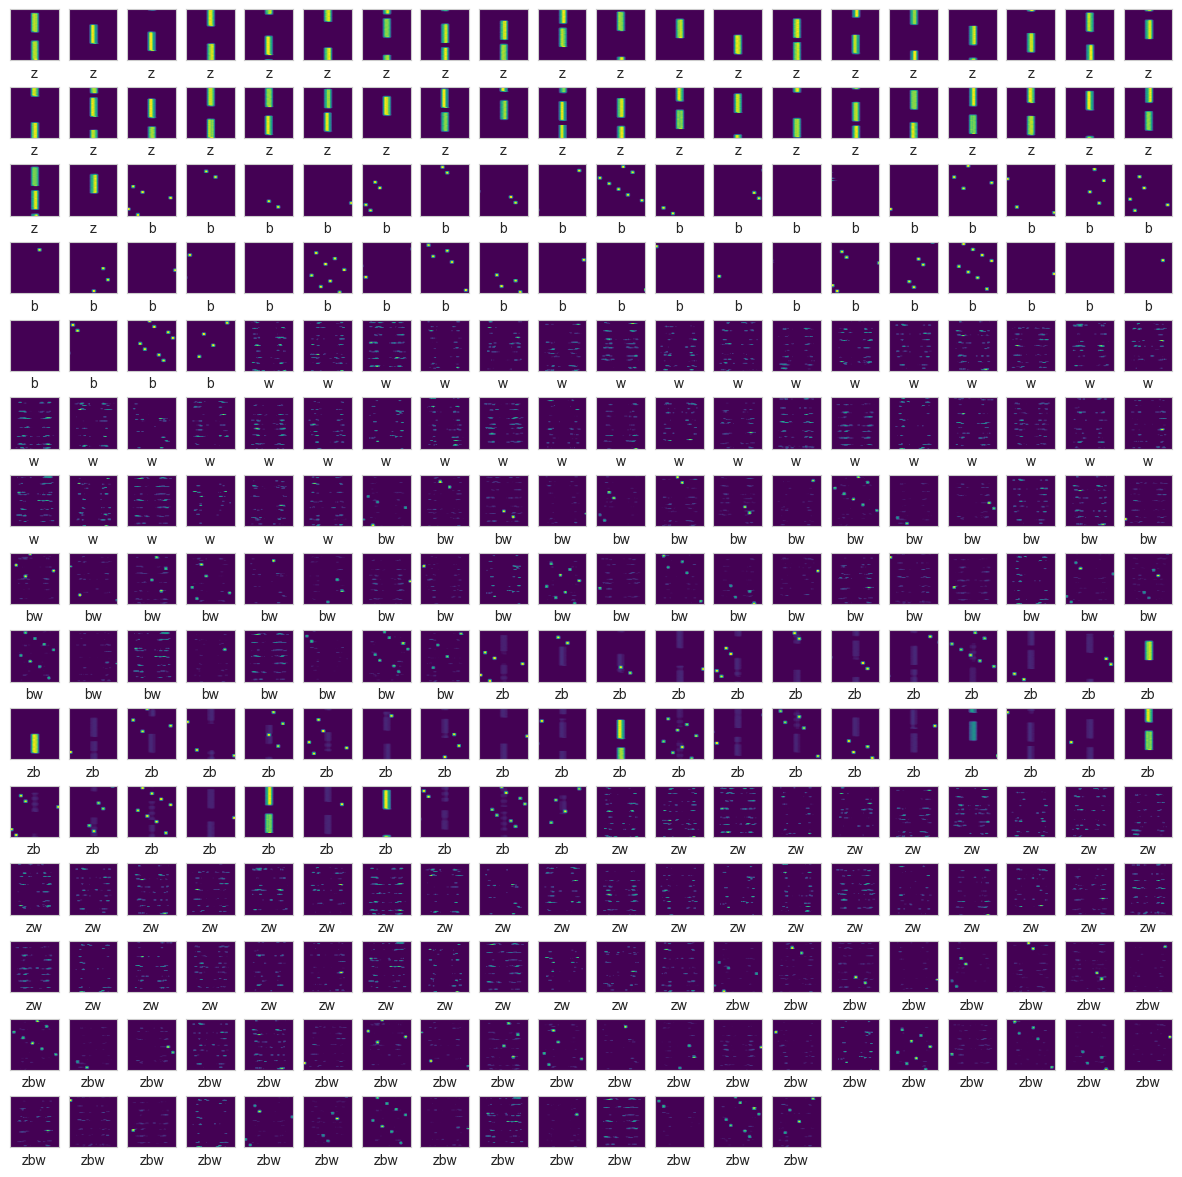

Number of training images: 205


In [7]:
# Reload spectrum painting module in case the code changed
# and you want what is executed to be what you told the computer
# to do.
reload(sp)

downsample_resolution = 64

K = 3
L = 4
D = 1

color_depth = 256

x_train_augmented: List[npt.NDArray[np.float32]] = []
x_train_painted: List[npt.NDArray[np.float32]] = []
labels: List[np.uint8] = []
label_names: List[str] = []

for (class_index, (label, spec)) in enumerate(spectrograms.items()):
    middle: int = len(spec.values) // 2
    start_freq: int = middle - 32
    end_freq: int = middle + 32

    spec = sp.take_frequencies(spec, start_freq, end_freq)

    slices = split_spectrogram(spec, duration=4000)

    downsampled_slices = [sp.downsample_spectrogram(s.values, downsample_resolution) for s in slices]
    augmented_slices = [sp.augment_spectrogram(s, K, L, D) for s in downsampled_slices]

    for s in augmented_slices:
        x_train_augmented.append(sp.digitize_spectrogram(s, color_depth))

    painted_slices = [sp.paint_spectrogram(original, augmented) for (original, augmented) in
                      list(zip(downsampled_slices, augmented_slices))]

    for s in painted_slices:
        x_train_painted.append(sp.digitize_spectrogram(s, color_depth))

    for i in range(len(slices)):
        labels.append(class_index)

    label_names.append(label)

plt.figure(figsize=(15, 20))
for i in range(len(x_train_painted)):
    image = x_train_painted[i]
    plt.subplot(20, 20, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image, cmap="viridis")
    plt.xlabel(label_names[labels[i]])
plt.show()

x_train_combined = np.stack((x_train_augmented, x_train_painted), axis=3)

x_train, x_test, y_train, y_test = train_test_split(x_train_combined, labels, test_size=0.3, random_state=42)

# for tensorflow it must be uint8 and not a Python int.
y_train = np.array(y_train, dtype=np.uint8)
y_test = np.array(y_test, dtype=np.uint8)

x_train_augmented = x_train[:, :, :, 0]
x_test_augmented = x_test[:, :, :, 0]

x_train_painted = x_train[:, :, :, 1]
x_test_painted = x_test[:, :, :, 1]

print(f"Number of training images: {len(x_train)}")


(64, 61, 1)
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 64, 61, 1)]          0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 64, 61, 1)]          0         []                            
                                                                                                  
 conv2d_6 (Conv2D)           (None, 58, 55, 64)           3200      ['input_3[0][0]']             
                                                                                                  
 conv2d_9 (Conv2D)           (None, 58, 55, 64)           3200      ['input_4[0][0]']             
                                                                                

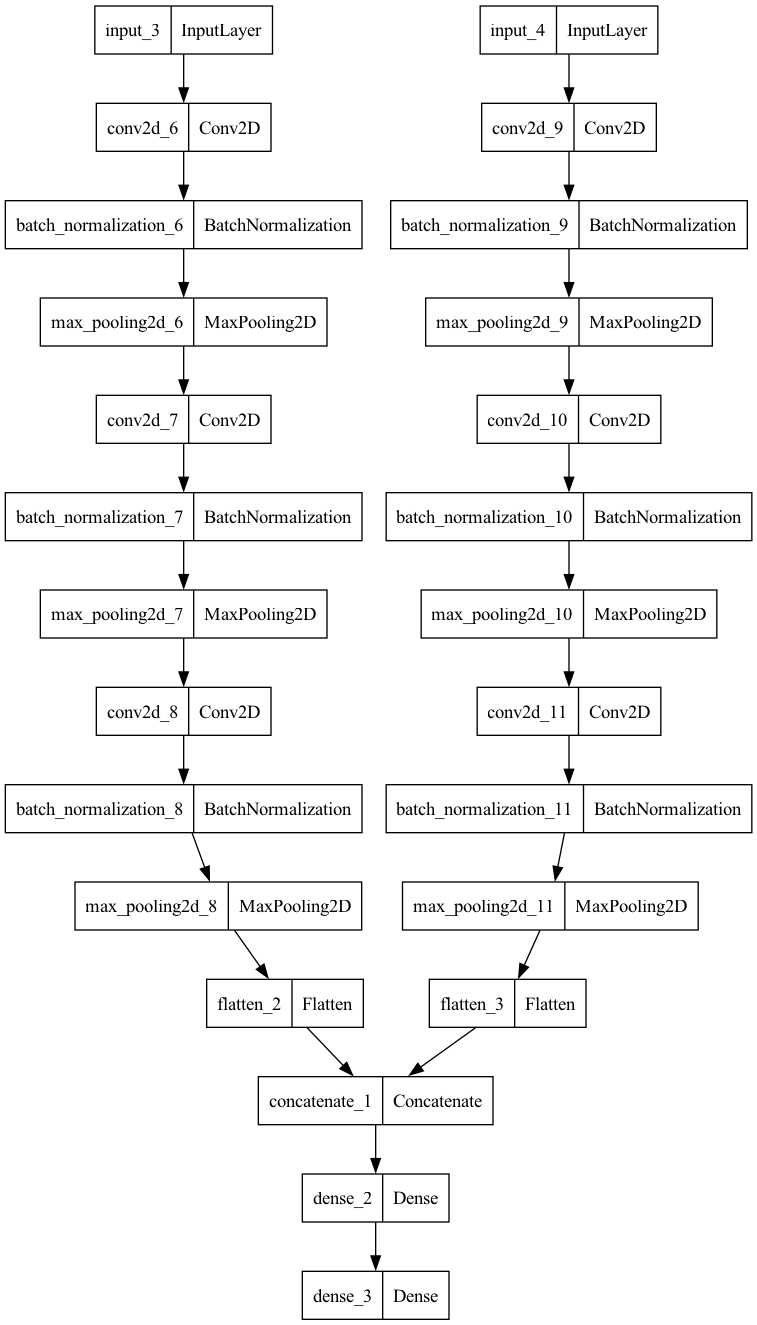

In [32]:
image_shape = x_train_augmented[0].shape
# The input shape to the CNN is the height, width and number of color channels. The spectrograms
# only have one color channel.
input_shape = (image_shape[0], image_shape[1], 1)
print(input_shape)

augmented_input = layers.Input(shape=input_shape)
augmented_model = layers.Conv2D(filters=64, kernel_size=(7, 7), activation='relu')(augmented_input)
augmented_model = layers.BatchNormalization()(augmented_model)
augmented_model = layers.MaxPooling2D((2, 2))(augmented_model)

augmented_model = layers.Conv2D(filters=32, kernel_size=(5, 5), activation='relu')(augmented_model)
augmented_model = layers.BatchNormalization()(augmented_model)
augmented_model = layers.MaxPooling2D((2, 2))(augmented_model)

augmented_model = layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(augmented_model)
augmented_model = layers.BatchNormalization()(augmented_model)
augmented_model = layers.MaxPooling2D((2, 2))(augmented_model)

# Flatten the 3D image output to 1 dimension
augmented_model = layers.Flatten()(augmented_model)
painted_input = layers.Input(shape=input_shape)
painted_model = layers.Conv2D(filters=64, kernel_size=(7, 7), activation='relu', input_shape=input_shape)(painted_input)
painted_model = layers.BatchNormalization()(painted_model)
painted_model = layers.MaxPooling2D((2, 2))(painted_model)

painted_model = layers.Conv2D(filters=32, kernel_size=(5, 5), activation='relu')(painted_model)
painted_model = layers.BatchNormalization()(painted_model)
painted_model = layers.MaxPooling2D((2, 2))(painted_model)

painted_model = layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(painted_model)
painted_model = layers.BatchNormalization()(painted_model)
painted_model = layers.MaxPooling2D((2, 2))(painted_model)

# Flatten the 3D image output to 1 dimension
painted_model = layers.Flatten()(painted_model)

output = layers.Concatenate()([augmented_model, painted_model])
output = layers.Dense(64, activation='relu')(output)

label_count = len(spectrograms)
output = layers.Dense(label_count)(output)

model = models.Model(inputs=[augmented_input, painted_input], outputs=[output])

model.summary()
tf.keras.utils.plot_model(model, to_file="output/model.png")

Epoch 1/150
7/7 [==============================] - 1s 91ms/step - loss: 2.4594 - accuracy: 0.3366 - val_loss: 27.4189 - val_accuracy: 0.1573
Epoch 2/150
7/7 [==============================] - 0s 27ms/step - loss: 1.3160 - accuracy: 0.5171 - val_loss: 27.3084 - val_accuracy: 0.2809
Epoch 3/150
7/7 [==============================] - 0s 26ms/step - loss: 0.9108 - accuracy: 0.6390 - val_loss: 24.6294 - val_accuracy: 0.1685
Epoch 4/150
7/7 [==============================] - 0s 26ms/step - loss: 0.7049 - accuracy: 0.7122 - val_loss: 19.4870 - val_accuracy: 0.2697
Epoch 5/150
7/7 [==============================] - 0s 28ms/step - loss: 0.6019 - accuracy: 0.7610 - val_loss: 15.6478 - val_accuracy: 0.3034
Epoch 6/150
7/7 [==============================] - 0s 30ms/step - loss: 0.5395 - accuracy: 0.7707 - val_loss: 11.9851 - val_accuracy: 0.3483
Epoch 7/150
7/7 [==============================] - 0s 32ms/step - loss: 0.5231 - accuracy: 0.7610 - val_loss: 10.7810 - val_accuracy: 0.3483
Epoch 8/150
7

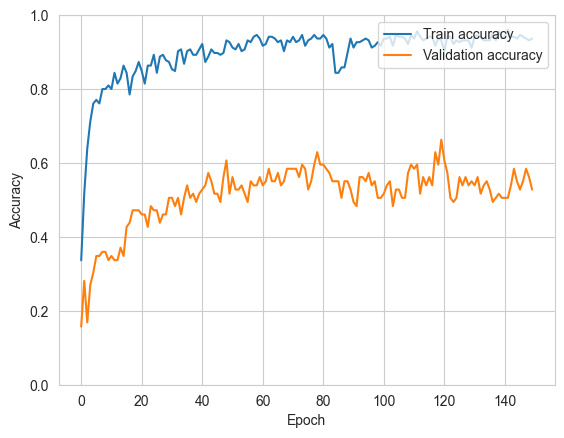

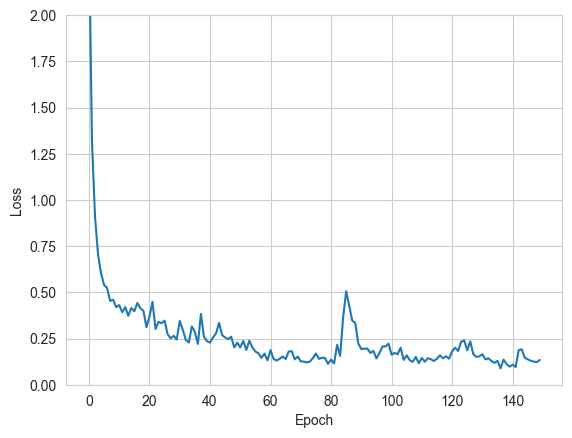

In [33]:
model.compile(optimizer='adam',
              loss=losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# convert ints to the type of int that can be used in a Tensor
history = model.fit(x=[x_train_augmented, x_train_painted],
                    y=y_train,
                    epochs=150,
                    validation_data=([x_test_augmented, x_test_painted], y_test))

plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='upper right')
plt.show()

plt.plot(history.history['loss'], label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 2])
plt.show()

In [36]:
final_loss, final_acc = model.evaluate([x_test_augmented, x_test_painted], y_test, verbose=1)
print("Final loss: {0:.6f}, final accuracy: {1:.6f}".format(final_loss, final_acc))

3/3 [==============================] - 0s 15ms/step - loss: 2.1415 - accuracy: 0.5281
Final loss: 2.141547, final accuracy: 0.528090


In [17]:
output_file = "output/spectrum-painting-model.keras"

tf.saved_model.save(model, "output/")
model.save(output_file)

INFO:tensorflow:Assets written to: output/assets


INFO:tensorflow:Assets written to: output/assets


In [12]:
def predict(x_augmented: npt.NDArray[np.uint8],
            x_painted: npt.NDArray[np.uint8]) -> str:
    x_augmented.shape += (1,)
    x_augmented = (np.expand_dims(x_augmented, 0))

    x_painted.shape += (1,)
    x_painted = (np.expand_dims(x_painted, 0))

    predictions_single = model.predict(x=[(x_augmented, x_painted)])
    prediction_index = np.argmax(predictions_single[0])
    return label_names[prediction_index]

1/1 [==============================] - 0s 10ms/step
[[15  0  0  0  2  0  0]
 [ 0  3  2  0  0  4  1]
 [ 0  1  7  0  0  0  7]
 [ 0  0  0 10  4  0  0]
 [ 2  0  0  2  6  0  0]
 [ 0  2  0  0  0  9  3]
 [ 0  0  5  0  0  1  3]]


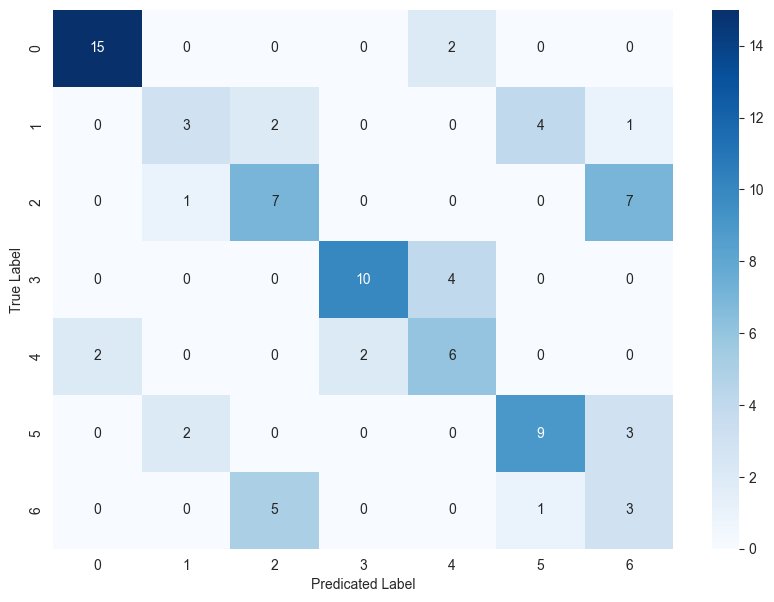

In [13]:
y_predictions = [predict(x_augmented, x_painted) for (x_augmented, x_painted) in zip(x_test_augmented, x_test_painted)]
cm = confusion_matrix(np.array(label_names)[y_test], y_predictions)
print(cm)
# cm = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]) * 100

plt.figure(figsize=(10, 7))
plot = seaborn.heatmap(cm, annot=True, cmap='Blues')
figure = plot.get_figure()
plt.ylabel('True Label')
plt.xlabel('Predicated Label')
plt.show()

In [14]:
# Convert the model
# This requires TensorFlow 2.15.0 for it to work. See https://github.com/tensorflow/tensorflow/issues/63987
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# TensorFlow Lite Micro does not support Hybrid models so disable the default optimizations for now
# until full quantization can be done.
# converter.optimizations = [tf.lite.Optimize.DEFAULT]

print("Converting...")
tflite_model = converter.convert()
print(f"Done. Model size = {len(tflite_model) // 1000} KB")

# Save the model.
with open('output/spectrum-painting-model.tflite', 'wb') as f:
    f.write(tflite_model)


Converting...
INFO:tensorflow:Assets written to: /var/folders/81/3wz7wxg90f3df6qvy1xbf71m0000gn/T/tmp9gi57rhg/assets


INFO:tensorflow:Assets written to: /var/folders/81/3wz7wxg90f3df6qvy1xbf71m0000gn/T/tmp9gi57rhg/assets


Done. Model size = 851 KB


2024-05-20 17:12:19.074210: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-20 17:12:19.074223: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-20 17:12:19.074771: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/81/3wz7wxg90f3df6qvy1xbf71m0000gn/T/tmp9gi57rhg
2024-05-20 17:12:19.076740: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-20 17:12:19.076747: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /var/folders/81/3wz7wxg90f3df6qvy1xbf71m0000gn/T/tmp9gi57rhg
2024-05-20 17:12:19.080858: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2024-05-20 17:12:19.083992: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-20 17:12:19.158051: I tensorflow/cc/saved_model/loader.

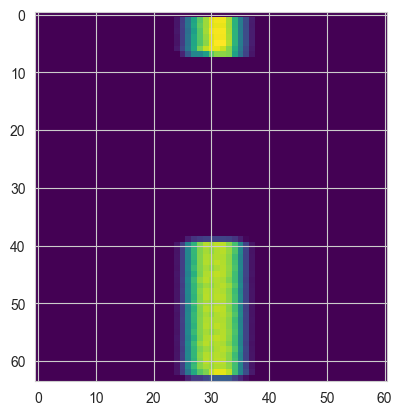

1/1 [==============================] - 0s 11ms/step
z


In [31]:
# Predict with full Tensorflow
test_img_augmented = x_test_augmented[0]
test_img_painted = x_test_painted[0]

plt.imshow(test_img_augmented, cmap='viridis')
plt.show()

prediction = predict(test_img_augmented, test_img_painted)

print(prediction)


In [ ]:
# Test with Tensorflow Lite

interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()[0]
output_details = interpreter.get_output_details()[0]

test_img_augmented = x_test_augmented[2]
test_img_painted = x_test_painted[2]

plt.imshow(test_img_augmented)
plt.show()

test_img_augmented.shape += (1,)
test_img_augmented = (np.expand_dims(test_img_augmented, 0))
test_img_augmented = test_img_augmented.astype(np.float32)

test_img_painted.shape += (1,)
test_img_painted = (np.expand_dims(test_img_painted, 0))
test_img_painted = test_img_painted.astype(np.float32)

interpreter.set_tensor(0, test_img_augmented)
interpreter.set_tensor(1, test_img_painted)

interpreter.invoke()

prediction = interpreter.get_tensor(output_details["index"])[0]
print(prediction)
prediction_index = np.argmax(prediction)
print(label_names[prediction_index])

In [ ]:
test_img_augmented = x_test_augmented[2]
test_img_painted = x_test_painted[2]

plt.imshow(test_img_augmented)
plt.show()

test_img_augmented.shape += (1,)
test_img_augmented = (np.expand_dims(test_img_augmented, 0))
test_img_augmented = test_img_augmented.astype(np.float32)

test_img_painted.shape += (1,)
test_img_painted = (np.expand_dims(test_img_painted, 0))
test_img_painted = test_img_painted.astype(np.float32)

with open('output/augmented_image.bytes', 'wb') as f:
    f.write(test_img_augmented.tobytes())

with open('output/painted_image.bytes', 'wb') as f:
    f.write(test_img_painted.tobytes())

# with serial.Serial("/dev/cu.usbmodem2101", timeout=5) as ser:
#     ser.write(augmented_bytes)
#     ser.write(painted_bytes)
#     print(ser.readline())
#     print(ser.readline())
#     print(ser.readline())
#     print(ser.readline())
#     print(ser.readline())
